In [1]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder


data_path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'


image_size = (256, 256)


image_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Grayscale normalization
])

mask_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])


def load_image_mask(image_path):
    mask_path = image_path.replace('.png', '_mask.png')
    
    if not os.path.exists(mask_path):
        return None, None

    image = Image.open(image_path).convert('L')
    mask = Image.open(mask_path).convert('L')

    image = image_transform(image)
    mask = mask_transform(mask)
    mask = (mask > 0.5).float()  # Binarize mask

    return image, mask


images, masks, labels = [], [], []
label_encoder = LabelEncoder()
class_names = ['normal', 'benign', 'malignant']
label_encoder.fit(class_names)


for class_name in class_names:
    class_dir = os.path.join(data_path, class_name)
    for fname in os.listdir(class_dir):
        if '_mask' not in fname and fname.endswith('.png'):
            image_path = os.path.join(class_dir, fname)
            image, mask = load_image_mask(image_path)
            
            if image is not None and mask is not None:
                images.append(image)
                masks.append(mask)
                labels.append(class_name)


X = torch.stack(images)
Y_masks = torch.stack(masks)
Y_labels = torch.tensor(label_encoder.transform(labels))

print(f"Images shape: {X.shape}")
print(f"Masks shape: {Y_masks.shape}")
print(f"Labels shape: {Y_labels.shape}")


Images shape: torch.Size([780, 1, 256, 256])
Masks shape: torch.Size([780, 1, 256, 256])
Labels shape: torch.Size([780])


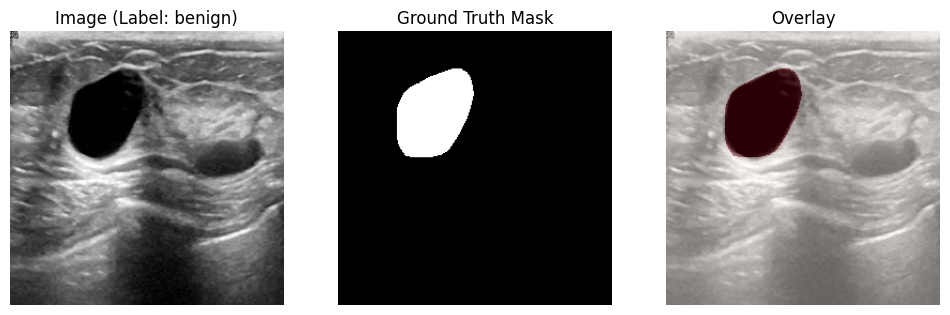

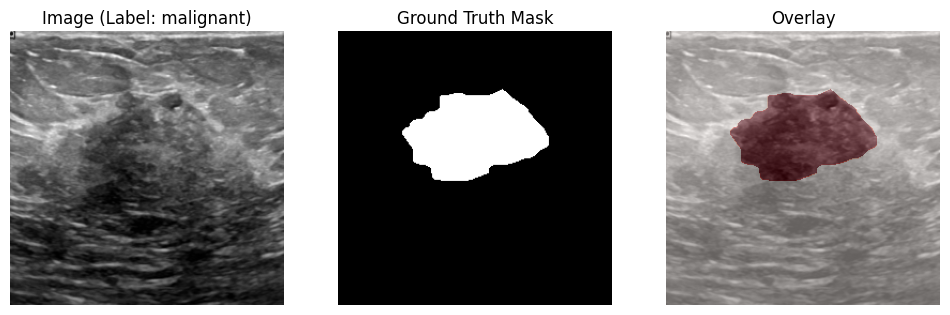

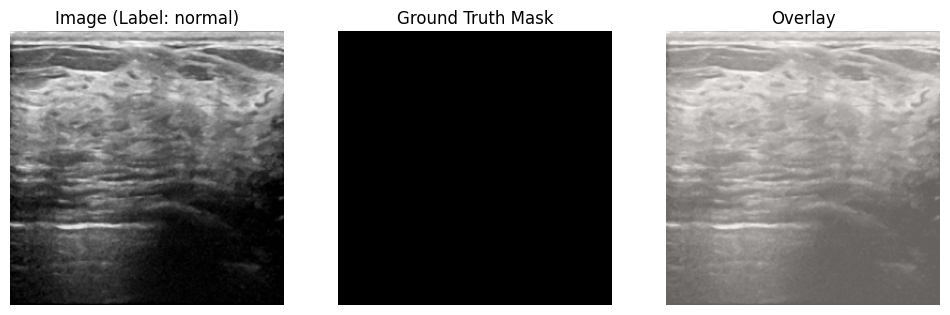

In [2]:
import matplotlib.pyplot as plt


def show_image_mask(index):
    image = X[index].squeeze().numpy()  # Remove channel dim
    mask = Y_masks[index].squeeze().numpy()
    label = label_encoder.inverse_transform([Y_labels[index].item()])[0]

    plt.figure(figsize=(12, 4))

   
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Image (Label: {label})")
    plt.axis('off')


    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

  
    plt.subplot(1, 3, 3)
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='Reds', alpha=0.4)  # overlay mask in red
    plt.title("Overlay")
    plt.axis('off')

    plt.show()



show_image_mask(300)
show_image_mask(700)
show_image_mask(100)


In [3]:
from torch.utils.data import Dataset

class BreastUltrasoundDataset(Dataset):
    def __init__(self, images, masks, labels):
        self.images = images
        self.masks = masks
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        label = self.labels[idx]
        return image, mask, label

In [4]:
from sklearn.model_selection import train_test_split

# Split indices
indices = list(range(len(X)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=Y_labels, random_state=42)


X_train = X[train_idx]
Y_masks_train = Y_masks[train_idx]
Y_labels_train = Y_labels[train_idx]

X_val = X[val_idx]
Y_masks_val = Y_masks[val_idx]
Y_labels_val = Y_labels[val_idx]


In [5]:
from torch.utils.data import DataLoader

# Create datasets
train_dataset = BreastUltrasoundDataset(X_train, Y_masks_train, Y_labels_train)
val_dataset = BreastUltrasoundDataset(X_val, Y_masks_val, Y_labels_val)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 39
Val batches: 10


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


In [8]:
class MultiTaskUNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        
        self.enc1 = DoubleConv(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        
        self.bottleneck = DoubleConv(512, 1024)

        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.segmentation_head = nn.Conv2d(64, 1, kernel_size=1)  # binary mask

        # Classification Head
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
       
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

       
        b = self.bottleneck(self.pool4(e4))

        
        d4 = self.upconv4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        d3 = self.upconv3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))
        seg_out = torch.sigmoid(self.segmentation_head(d1))  # binary mask (0–1)

        # Classification Head
        pooled = self.global_pool(b)
        cls_out = self.classifier(pooled)  # logits (will apply softmax in loss)

        return seg_out, cls_out


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskUNet(num_classes=3).to(device)
print("Using device:", device)

Using device: cuda


In [10]:
# Losses
seg_loss_fn = nn.BCELoss()  # for binary segmentation output
cls_loss_fn = nn.CrossEntropyLoss()  # for 3-class classification

In [11]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 40
alpha, beta = 1.0, 0.5  # loss weights


In [12]:
from tqdm import tqdm

def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for images, masks, labels in tqdm(loader):
        images = images.to(device)
        masks = masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        seg_preds, cls_preds = model(images)

        seg_loss = seg_loss_fn(seg_preds, masks)
        cls_loss = cls_loss_fn(cls_preds, labels)
        loss = alpha * seg_loss + beta * cls_loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, masks, labels in loader:
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            seg_preds, cls_preds = model(images)

            seg_loss = seg_loss_fn(seg_preds, masks)
            cls_loss = cls_loss_fn(cls_preds, labels)
            loss = alpha * seg_loss + beta * cls_loss

            total_loss += loss.item()

            _, predicted = torch.max(cls_preds, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


In [13]:
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_loss, val_acc = eval_epoch(model, val_loader)

    print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved best model.")


100%|██████████| 39/39 [00:30<00:00,  1.28it/s]


[Epoch 1/40] Train Loss: 0.9713 | Val Loss: 1.0975 | Val Acc: 0.2821
Saved best model.


100%|██████████| 39/39 [00:31<00:00,  1.25it/s]


[Epoch 2/40] Train Loss: 0.7909 | Val Loss: 0.7443 | Val Acc: 0.6923
Saved best model.


100%|██████████| 39/39 [00:33<00:00,  1.16it/s]


[Epoch 3/40] Train Loss: 0.7022 | Val Loss: 0.7237 | Val Acc: 0.6923
Saved best model.


100%|██████████| 39/39 [00:36<00:00,  1.08it/s]


[Epoch 4/40] Train Loss: 0.6362 | Val Loss: 0.9438 | Val Acc: 0.6474


100%|██████████| 39/39 [00:34<00:00,  1.13it/s]


[Epoch 5/40] Train Loss: 0.5953 | Val Loss: 1.0560 | Val Acc: 0.6667


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 6/40] Train Loss: 0.5831 | Val Loss: 0.7969 | Val Acc: 0.5769


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 7/40] Train Loss: 0.5403 | Val Loss: 0.7113 | Val Acc: 0.5705
Saved best model.


100%|██████████| 39/39 [00:34<00:00,  1.12it/s]


[Epoch 8/40] Train Loss: 0.5030 | Val Loss: 0.6069 | Val Acc: 0.7179
Saved best model.


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 9/40] Train Loss: 0.4835 | Val Loss: 0.6141 | Val Acc: 0.7308


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 10/40] Train Loss: 0.4402 | Val Loss: 0.7014 | Val Acc: 0.6282


100%|██████████| 39/39 [00:34<00:00,  1.12it/s]


[Epoch 11/40] Train Loss: 0.4209 | Val Loss: 0.6053 | Val Acc: 0.6923
Saved best model.


100%|██████████| 39/39 [00:34<00:00,  1.12it/s]


[Epoch 12/40] Train Loss: 0.3782 | Val Loss: 0.5302 | Val Acc: 0.7821
Saved best model.


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 13/40] Train Loss: 0.3838 | Val Loss: 0.5352 | Val Acc: 0.7436


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 14/40] Train Loss: 0.3430 | Val Loss: 0.6332 | Val Acc: 0.7372


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 15/40] Train Loss: 0.3336 | Val Loss: 0.9262 | Val Acc: 0.6859


100%|██████████| 39/39 [00:34<00:00,  1.11it/s]


[Epoch 16/40] Train Loss: 0.2993 | Val Loss: 0.5345 | Val Acc: 0.7692


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 17/40] Train Loss: 0.2760 | Val Loss: 0.8629 | Val Acc: 0.5128


100%|██████████| 39/39 [00:34<00:00,  1.12it/s]


[Epoch 18/40] Train Loss: 0.2913 | Val Loss: 0.4904 | Val Acc: 0.7756
Saved best model.


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 19/40] Train Loss: 0.2555 | Val Loss: 0.5248 | Val Acc: 0.8141


100%|██████████| 39/39 [00:35<00:00,  1.10it/s]


[Epoch 20/40] Train Loss: 0.2156 | Val Loss: 0.4674 | Val Acc: 0.8333
Saved best model.


100%|██████████| 39/39 [00:35<00:00,  1.10it/s]


[Epoch 21/40] Train Loss: 0.1941 | Val Loss: 0.5486 | Val Acc: 0.8013


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 22/40] Train Loss: 0.2062 | Val Loss: 0.9231 | Val Acc: 0.5833


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 23/40] Train Loss: 0.2113 | Val Loss: 0.4959 | Val Acc: 0.7885


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 24/40] Train Loss: 0.1890 | Val Loss: 0.5480 | Val Acc: 0.8141


100%|██████████| 39/39 [00:34<00:00,  1.12it/s]


[Epoch 25/40] Train Loss: 0.1829 | Val Loss: 0.5175 | Val Acc: 0.8269


100%|██████████| 39/39 [00:34<00:00,  1.12it/s]


[Epoch 26/40] Train Loss: 0.1654 | Val Loss: 0.4829 | Val Acc: 0.8333


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 27/40] Train Loss: 0.1622 | Val Loss: 0.5387 | Val Acc: 0.8205


100%|██████████| 39/39 [00:35<00:00,  1.10it/s]


[Epoch 28/40] Train Loss: 0.1455 | Val Loss: 0.5562 | Val Acc: 0.8333


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 29/40] Train Loss: 0.1403 | Val Loss: 0.5206 | Val Acc: 0.8013


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 30/40] Train Loss: 0.1363 | Val Loss: 0.5114 | Val Acc: 0.8141


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 31/40] Train Loss: 0.1379 | Val Loss: 0.4871 | Val Acc: 0.8077


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 32/40] Train Loss: 0.1178 | Val Loss: 0.5263 | Val Acc: 0.7692


100%|██████████| 39/39 [00:34<00:00,  1.12it/s]


[Epoch 33/40] Train Loss: 0.1106 | Val Loss: 0.4948 | Val Acc: 0.8333


100%|██████████| 39/39 [00:34<00:00,  1.11it/s]


[Epoch 34/40] Train Loss: 0.1006 | Val Loss: 0.4602 | Val Acc: 0.8205
Saved best model.


100%|██████████| 39/39 [00:34<00:00,  1.12it/s]


[Epoch 35/40] Train Loss: 0.1023 | Val Loss: 0.6731 | Val Acc: 0.7821


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 36/40] Train Loss: 0.1007 | Val Loss: 0.6629 | Val Acc: 0.8077


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 37/40] Train Loss: 0.1104 | Val Loss: 0.5633 | Val Acc: 0.8269


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 38/40] Train Loss: 0.1050 | Val Loss: 0.5571 | Val Acc: 0.8141


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 39/40] Train Loss: 0.0870 | Val Loss: 0.4817 | Val Acc: 0.7949


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


[Epoch 40/40] Train Loss: 0.0985 | Val Loss: 0.5258 | Val Acc: 0.8077


In [14]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


/tmp/ipykernel_19/1817869122.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


MultiTaskUNet(
  (enc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
 

In [15]:
def dice_coeff(pred, target, eps=1e-7):
    pred = (pred > 0.5).float().cpu()
    target = target.float().cpu()
    intersection = (pred * target).sum().item()
    union = pred.sum().item() + target.sum().item()
    return (2 * intersection + eps) / (union + eps)

def iou_score(pred, target, eps=1e-7):
    pred = (pred > 0.5).float().cpu()
    target = target.float().cpu()
    intersection = (pred * target).sum().item()
    union = ((pred + target) > 0).float().sum().item()
    return (intersection + eps) / (union + eps)

def pixel_accuracy(pred, target):
    pred = (pred > 0.5).float().cpu()
    target = target.float().cpu()
    correct = (pred == target).float().sum().item()
    total = pred.numel()
    return correct / total



In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def classification_metrics(y_true, y_pred):
    y_true = torch.cat(y_true).cpu().numpy()
    y_pred = torch.cat(y_pred).cpu().numpy()
    
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='macro'),
        "Recall": recall_score(y_true, y_pred, average='macro'),
        "F1-Score": f1_score(y_true, y_pred, average='macro')
    }


In [17]:
def evaluate_model(model, loader):
    model.eval()
    dice_scores, iou_scores, acc_scores = [], [], []
    cls_true, cls_pred = [], []

    with torch.no_grad():
        for images, masks, labels in loader:
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            seg_preds, cls_preds = model(images)

            for i in range(images.size(0)):
                pred_mask = seg_preds[i].cpu()
                true_mask = masks[i].cpu()

                dice_scores.append(dice_coeff(pred_mask, true_mask))
                iou_scores.append(iou_score(pred_mask, true_mask))
                acc_scores.append(pixel_accuracy(pred_mask, true_mask))

            _, predicted = torch.max(cls_preds, 1)
            cls_true.append(labels.cpu())
            cls_pred.append(predicted.cpu())

    classification_results = classification_metrics(cls_true, cls_pred)

    print("\n Segmentation Metrics:")
    print(f"Mean Dice Coefficient: {np.mean(dice_scores):.4f}")
    print(f"Mean IoU: {np.mean(iou_scores):.4f}")
    print(f"Mean Pixel Accuracy: {np.mean(acc_scores):.4f}")

    print("\n Classification Metrics:")
    for k, v in classification_results.items():
        print(f"{k}: {v:.4f}")



In [18]:
evaluate_model(model, val_loader)



 Segmentation Metrics:
Mean Dice Coefficient: 0.6976
Mean IoU: 0.6188
Mean Pixel Accuracy: 0.9581

 Classification Metrics:
Accuracy: 0.8205
Precision: 0.8042
Recall: 0.8378
F1-Score: 0.8129


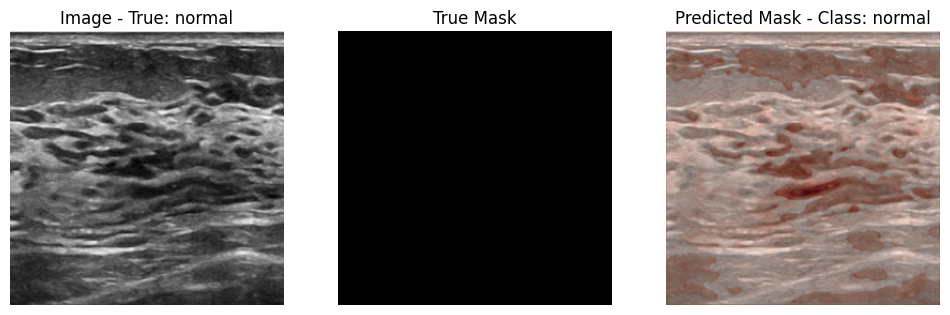

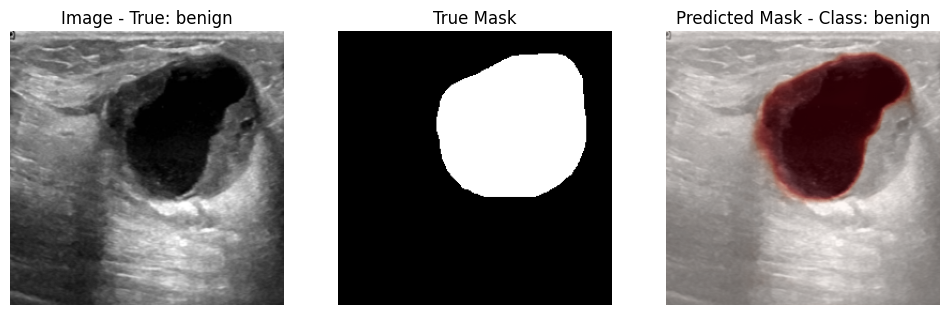

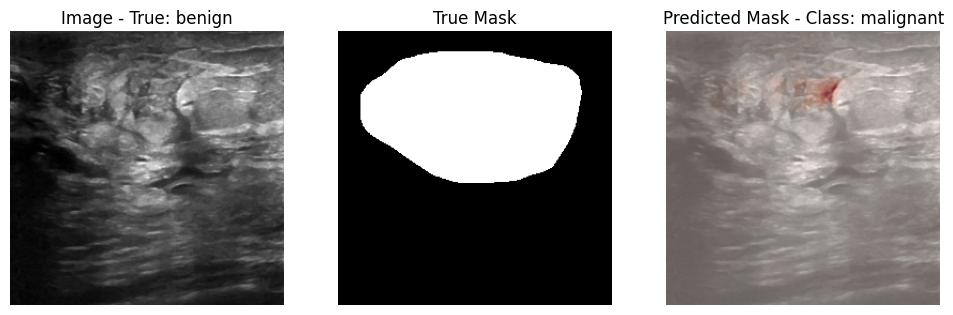

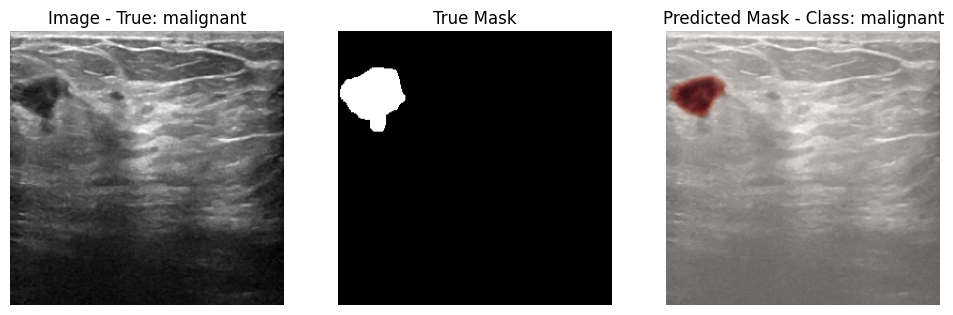

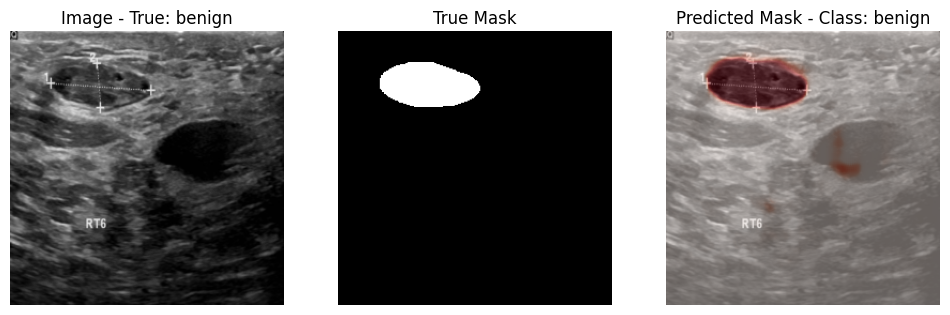

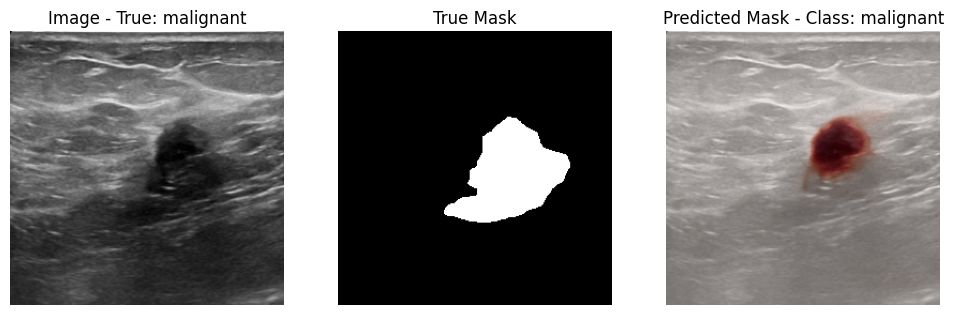

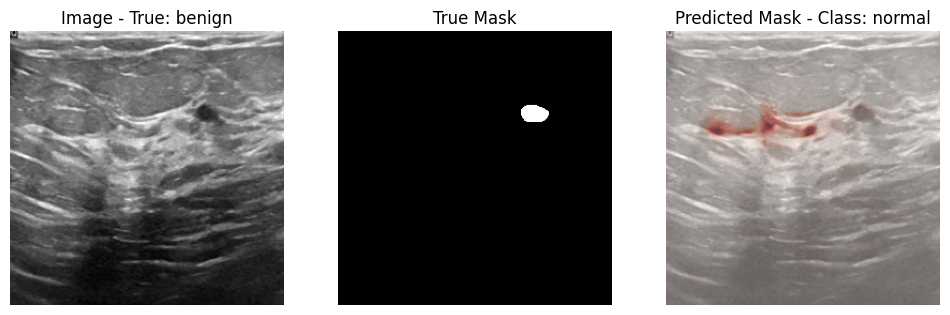

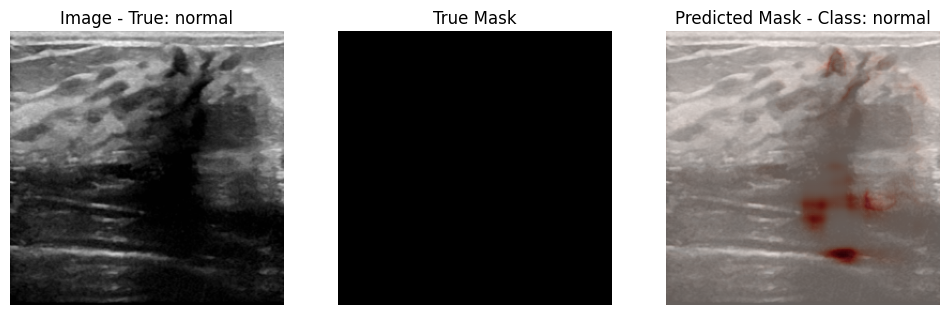

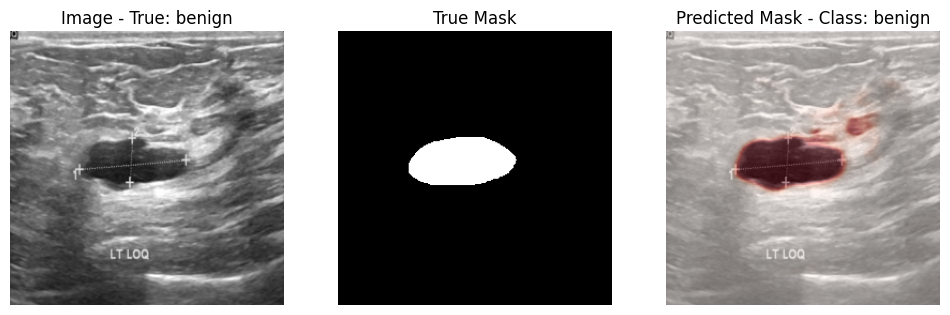

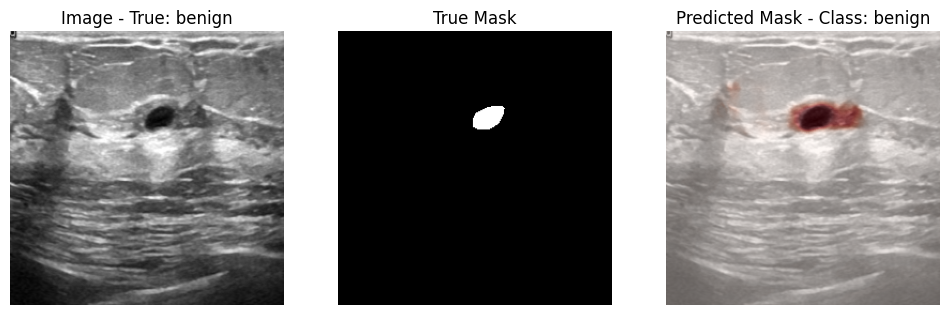

In [19]:
import matplotlib.pyplot as plt

def visualize_prediction(index, dataset):
    model.eval()
    image, mask, label = dataset[index]
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        seg_pred, cls_pred = model(image_tensor)
    
    pred_mask = seg_pred.squeeze().cpu().numpy()
    true_mask = mask.squeeze().numpy()
    image_np = image.squeeze().numpy()
    
    label_name = label_encoder.inverse_transform([label])[0]
    pred_label = label_encoder.inverse_transform([cls_pred.argmax(dim=1).item()])[0]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image_np, cmap='gray')
    plt.title(f"Image - True: {label_name}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image_np, cmap='gray')
    plt.imshow(pred_mask, cmap='Reds', alpha=0.4)
    plt.title(f"Predicted Mask - Class: {pred_label}")
    plt.axis('off')

    plt.show()

# Example
for i in range(50,60):
    visualize_prediction(i, val_dataset)


In [20]:
import matplotlib.pyplot as plt
import glob

def predict_and_visualize_from_folder(folder_path):
    image_paths = glob.glob(os.path.join(folder_path, "*.png")) + \
                  glob.glob(os.path.join(folder_path, "*.jpg"))

    for image_path in sorted(image_paths):
        image = Image.open(image_path).convert('L')
        input_tensor = image_transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            pred_mask, class_logits = model(input_tensor)

        pred_mask = pred_mask.squeeze().cpu().numpy()
        class_id = class_logits.argmax(dim=1).item()
        class_name = label_encoder.inverse_transform([class_id])[0]


        # Visualization
        image_np = np.array(image.resize((256, 256)))
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(image_np, cmap='gray')
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(image_np, cmap='gray')
        plt.imshow(pred_mask, cmap='Reds', alpha=0.4)
        plt.title(f"Overlay - Class: {class_name}")
        plt.axis('off')

        plt.suptitle(f"File: {os.path.basename(image_path)}", fontsize=12)
        plt.tight_layout()
        plt.show()



In [21]:
#predict_and_visualize_from_folder("/kaggle/input/test-case/test_data")